# 출차 시 사용될 코드

# library

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
import easyocr

# Webcam

In [4]:
# 노트북 자체의 캠은 0번
webcam = cv2.VideoCapture(0)

#-- 웹캠 오류 처리 
if not webcam.isOpened():
    print("WebCam is not running")
    exit()
     
time_num= 0    
image_num = 0
    
#-- 웹캠 열기
while webcam.isOpened():
         
    status, frame = webcam.read()
    time_num = time_num + 1
    
    if not status:
        break
 
    #-- 출력창
    # plt.imshow("WebCam", frame)
    
    #-- 캡쳐 프레임 간격 설정
    if time_num == 1:
        image_num = image_num + 1
        cv2.imwrite('./image/outro_image/img.png', frame) #-- 본인 편의에 맞게 경로 설정 및 이미지 이름 변경
        time_num = 0
        if image_num == 1:
            break
    
webcam.release()

# Yolo & OCR

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
c:\Python39\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


클래스 번호:  1 
클래스: elec 
elec일 확률:  0.9957979917526245


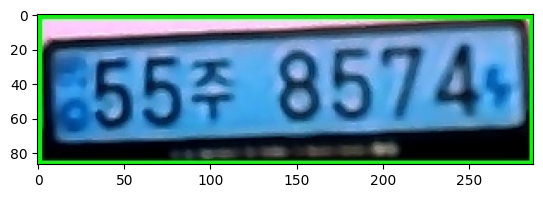

In [5]:

img_path = './image/outro_image/img.png'

img = cv2.imread(img_path)

with open('obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('yolov4-tiny-custom.cfg', 'yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)
try :
  classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

  clss = classIds.tolist()
  score = scores.tolist()

  # 주차딱지 변수 값 지정
  # Object Detection 했을 때 주차딱지가 Detection 안 되면 class_num_y와 class_name_yellow 는 'x'값을 가짐
  # 주차딱지가 Detection 되면 class_num_y는 '3', class_name_yellow 는 '주차딱지' 값을 가짐 (아래에 있는 if 문)

  class_num_y = '0'
  class_name_yellow = 'x'

  reader = easyocr.Reader(['ko'])

  # # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

  for i in range(len(clss)):
      box = boxes[i].tolist()
      w = box[0]
      h = box[1]
      x = box[2]
      y = box[3]
      bbox = img[h:y+h, w:x+w]



      if clss[i] == 0:
          print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])

          # 22.11.05  옮김 ㅎㅅㅇ
          class_num = str(clss[i])
          class_name = '일반'
          

          cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
          #cv2.imshow(bbox)
          cv2.imwrite('./image/outro_image/norm.jpg', bbox) #저장

          #22.11.05 추가 ㅎㅅㅇ
          norm = Image.open('./image/outro_image/norm.jpg')

          if bbox is None:
              print('Image load failed!')
              bbox.exit()

          src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

          # 설정한 검은색의 rgb 범위 (0, 0, 0) ~ (80, 80, 80)
          dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
          cv2.imwrite('./image/outro_image/norm_black.jpg', dst1)

          norm_black = Image.open('./image/outro_image/norm_black.jpg')

          # 가로 세로 길이 조절
          norm_black = norm_black.resize((int(norm_black.width), int(norm_black.height)))
          norm_black.save('./image/outro_image/norm_black.jpg')
          norm_black = Image.open('./image/outro_image/norm_black.jpg')

          # ------------ OCR
          result = reader.readtext(norm_black)

          #result에서 00가0000 형태인지 찾기
                  # 22.11.05 수정 ㅎㅅㅇ
          for a in result:
            if re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
              pass
            elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
              norm_re = norm_black.resize((int(norm_black.width*2), int(norm_black.height)))         
              plt.figure()
              plt.imshow(norm_re)
              norm_re.save('./image/outro_image/norm_re.jpg',)
              norm_re=Image.open('./image/outro_image/norm_re.jpg')
              result = reader.readtext(norm_re)

          # 22.11.05 추가  ㅎㅅㅇ      
          if 0<=len(result)<= 6:
              norm_norm = Image.open("./image/outro_image/norm.jpg")
              plt.imshow(norm_norm)
              result = reader.readtext(norm_norm)


      elif clss[i] == 1:
          print('클래스 번호: ', clss[i], '\n클래스: elec', '\nelec일 확률: ', score[i])

          #22.11.05 옮김 ㅎㅅㅇ
          class_num = str(clss[i])
          class_name = '전기'

          cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
          #cv2.imshow(bbox)
          cv2.imwrite('./image/outro_image/elec.jpg', bbox)

          #22.11.05 추가 ㅎㅅㅇ
          elec = Image.open('./image/outro_image/elec.jpg')

          if bbox is None:
              print('Image load failed!')
              bbox.exit()

          src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

          dst1 = cv2.inRange(bbox, (0, 0, 0), (70, 80, 80))
          cv2.imwrite('./image/outro_image/elec_black.jpg', dst1)
          elec_black = Image.open('./image/outro_image/elec_black.jpg')

          # 가로 세로 길이 조절
          elec_black = elec_black.resize((int(elec_black.width), int(elec_black.height)))
          elec_black.save('./image/outro_image/elec_black.jpg')
          elec_black = Image.open('./image/outro_image/elec_black.jpg')
          

          # ------------ OCR
          result = reader.readtext(elec_black)

              # result에서 00가0000 형태인지 찾기
              #22.11.05 수정 ㅎㅅㅇ
          for a in result:
            if re.match(r'[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
                pass
            elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
              elec_re = elec_black.resize((int(elec_black.width*2), int(elec_black.height)))
              plt.figure()
              elec_re.save('./image/outro_image/elec_re.jpg')
              elec_re=Image.open('./image/outro_image/elec_re.jpg')
              result = reader.readtext(elec_re)
              
          elec_norm = Image.open("./image/outro_image/elec.jpg")
          plt.imshow(elec_norm)
          # #22.11.05 추가 ㅎㅅㅇ
          if 0<=len(result)<= 6:
              elec_norm = Image.open("./image/outro_image/elec.jpg")
              plt.imshow(elec_norm)
              result = reader.readtext(elec_norm)

      if clss[i] == 3:
          print('클래스 번호: ', clss[i], '\n클래스: yellow', '\nyellow일 확률: ', score[i])
          cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
          #cv2.imshow(bbox)
          class_num_y = '1'
          class_name_yellow = '주차딱지'
except :
  print('====IMG_ERR====')



# 문자추출

In [6]:
def result_plate():
    result_list = []

    # 번호판으로 올 수 있는 문자만 추출 하기 위함.
    plate = ['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '버', '서', '어', '저', '고', '노', '도', '로', '모', '보', '소', '오', '조', '구', '누', '두', '루', '무', '부', '수', '우', '주', '허', '하', '호', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    first_num = ''
    second_num = ''
    str_cnt = 0 # 앞 번호판의 문자 (1글자)만 읽기 위함.

    for i in result :
        for j in i[1] :
            for str in plate :
                if j == str :
                    result_list.append(j)
                
            # 문자를 기준으로 앞번호 , 뒷 번호를 슬라이싱.
            if '가'<=j<='힣' and str_cnt == 0 : 
                str_cnt += 1
                first_num=result_list[:result_list.index(j)+1]
                second_num=result_list[result_list.index(j)+1:] 
                
            # 형식에 맞게 들어왔는지 체크.
                if 3<=len(first_num)<=4 :
                    first_num = ''.join(first_num)
                else :
                    first_num = 'error'

        # 앞 번호 문자 추출이후 뒷 번호를 한번 더 체크
        # 번호판 앞 번호와 뒷 번호가 분리되지 않고 result로 들어온 경우. ex) '101하 4609'
        # 번호판 앞 번호와 뒷 번호가 분리되어 result로 들어온 경우. ex)'101하' , '4609'
        # 번호판 뒷 번호에 필요없는 문자가 섞여있는 경우 ex)'107rㄱㄱ1 6540가00' 모두 걸러냄.
        
            else :
                result_list2 = [n for n in result_list if '0'<=n<='9' not  in result_list]
                if len(result_list2)== 0 :
                    result_list2 = [n for n in result_list if '0'<=n<='9' in result_list]
                second_num = ''.join(result_list2[-4:])

    return first_num,second_num
first_num , second_num = result_plate()


In [7]:
print(#'클래스 번호:', class_num,
      # '\n클래스 이름: ', class_name,
      '\n차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)


차량번호 앞자리:  55주 
차량번호 뒷자리:  8574


# 출차 시간

In [8]:
from datetime import datetime

def car_time():
    now = datetime.now()
    return '{0:0>2}'.format(str(now.hour)) + ":" + '{0:0>2}'.format(str(now.minute))

out_time = car_time()

In [9]:
out_time

'16:55'

# 주차 금액 정산

In [11]:
import pandas as pd
import pymysql
from datetime import datetime

now = datetime.now()

conn = pymysql.connect(host='localhost', user='root', password='multi123', db = 'car_manager', charset='utf8')
    
# Dict형식의 CURSOR  
cur = conn.cursor(pymysql.cursors.DictCursor)

# SQL 작성 
sql_in = "select * from total_info"

# SQL 실행
cur.execute(query=sql_in)

# 결과 가져오기
result_in = cur.fetchall()

df_in = pd.DataFrame(result_in)

find = df_in[df_in['last_number'] == second_num]

##출차시 사용할 함수

def calc_price():
    out = datetime.now()
    
    # 출차 에러 처리 (정산 요금이 없거나( out.hour, out.minute 실행시 0 일 때)
    #                 테이블에 입차한 차량(second_num)의 정보가 없을때 발생)
    try :
        if out.minute > int(find['intro_time'].values[0].split(':')[1]):
            h = (out.hour - int(find['intro_time'].values[0].split(':')[0]))
            m = out.minute - int(find['intro_time'].values[0].split(':')[1])
        elif out.minute < int(find['intro_time'].values[0].split(':')[1]):
            h = (out.hour - int(find['intro_time'].values[0].split(':')[0])) - 1
            m = out.minute + (60 - int(find['intro_time'].values[0].split(':')[1]))

        if find['car_elec'].values[0] == '0':
            if find['person_type'].values[0] == '0':
                price = h*60*100 + m*100
            elif find['person_type'].values[0] == '1':
                price = 0
        elif find['car_elec'].values[0] == '1':
            if find['person_type'].values[0] == '0':
                price = h*60*50 + m*50
            elif find['person_type'].values[0] == '1':
                price = 0

    # 예외 발생시 프린트 구문
    except :
        print('정산할 요금이 없습니다.')
        price = 0

    # 정산 금액이 만원 이하일때 금액 앞 문자열을 '0' 으로 채움. => str형식
    return '{0:0>5}'.format(price)

In [12]:
price = calc_price()

정산할 요금이 없습니다.


# 주차요금 정산 후 total_info에서 해당 차량 정보 삭제

In [13]:
# 출차시 total_info에서 삭제 하는 구문 추가 ==> 같은 차량이 다시 주차하는 상황을 처리하기 위함.
cur.execute(f'delete from total_info where last_number = \"{second_num}\" ;')
conn.commit()

# outro_info 에 저장
## outro_info : 출차 시 LCD 모니터에 띄울 정보를 str 타입으로 된 한 줄의 정보를 저장하는 테이블

In [14]:
first_num = '{0:0>4}'.format(first_num)

In [16]:
import pymysql

conn = pymysql.connect(host='localhost', user='root', password='multi123', db = 'car_manager', charset='utf8')

cur = conn.cursor()

#아랫줄은 제일 처음에 table 생성 시에만 사용함
#cur.execute("create table outro_info (outro_str varchar(30))")

cur.execute(f"insert into outro_info values(\"{second_num}{first_num}{find['person_type'].values[0]}{find['car_elect'].values[0]}{out_time}{price}\")")

conn.commit()